# Preparations

In [1]:
import sys
import os
import ast
import time
import datetime
import warnings
import eli5

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from PIL import Image
from numpy.linalg import norm
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, LassoLarsCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('max_rows', 10)
sns.set(style='white', context='notebook', palette='deep')

D:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Read data from .csv file

In [2]:
train_data = pd.read_csv('./train.csv', )
test_data = pd.read_csv('./test.csv', )
train_data.shape, test_data.shape

((3000, 23), (4398, 22))

We have 3000 training examples, and 4398 test examples.

Let's see what the data look like:

In [3]:
train_data.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


We can see that many features (e.g. spoken language, keywords) are in dictionary forms, we need to pay special attention to treating those features carefully.

# Data Exploration
Let's first find out what are the numerical features, and what are the categorical features.

In [4]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
                
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col], color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
            
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

## Numerical features

In [5]:
train_data.select_dtypes(include=['int64','float64']).columns.values

array(['id', 'budget', 'popularity', 'runtime', 'revenue'], dtype=object)

In [6]:
# Summary statistics on numerical features, excluding the id
train_data.drop(labels=['id'], axis=1).describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


- There are 4 numerical features in total.
- The minimum of budget is 0, which is a value that we need to pay attention to.
- There are some missing values in the runtime, and the minimum of runtime is 0, which does not make sense (a movie has length 0??). We need to treat this feature carefully.
- Revenue has a standard deviation of 1.375e+8, which is a bit too crazy! The minimum is only one dollar!

### Univariate distributions

<Figure size 432x288 with 0 Axes>

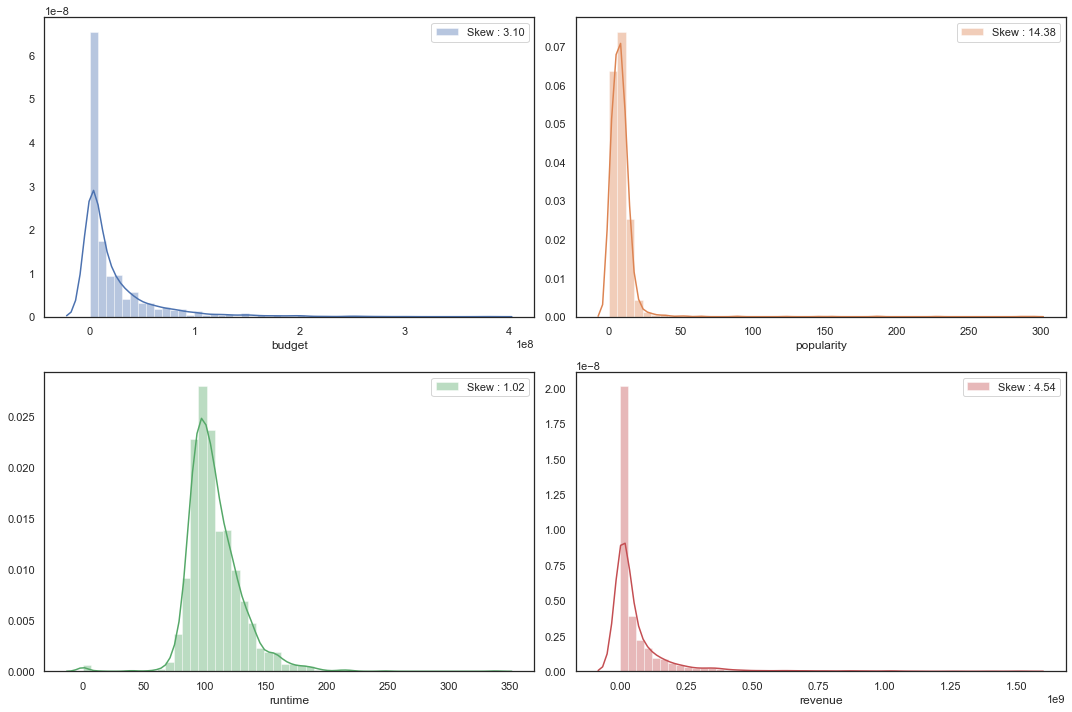

<Figure size 432x288 with 0 Axes>

In [7]:
# Let's visualize the distributions of numerical features
numerical_features = ['budget', 'popularity', 'runtime', 'revenue']
multiplot(train_data, numerical_features, 'distplot', nrows=2, ncols=2, figsize=(15,10), colorize=True)

There are some outliers in **budget, popularity, and revenue,** that make their distibutions highly skewed to the right.

### Multivariate visualizations
Let's visualize the relations of budget, popularity, and runtime, with respect to the target variable, **revenue**.

Text(0.5, 1.0, 'Correlation 0.46')

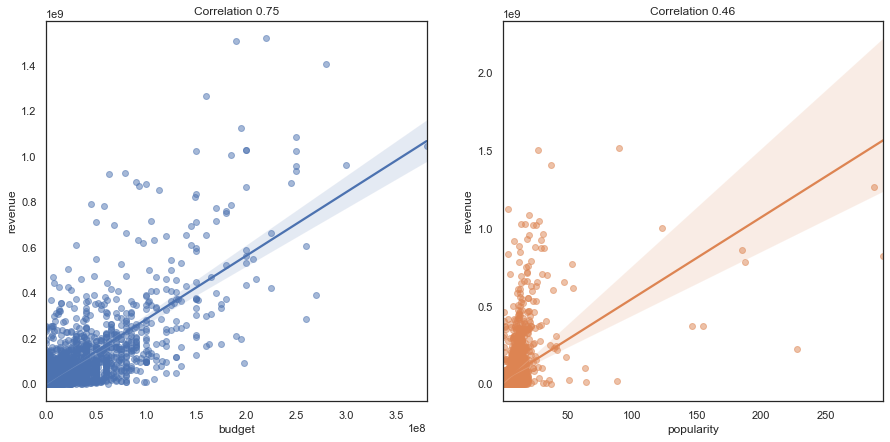

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
colors = sns.color_palette(n_colors=2)
sns.set(color_codes=True)

sns.regplot(x=train_data['budget'], y=train_data['revenue'], ax=axes[0], color=colors[0], scatter_kws={'alpha': 0.5})
correlation = np.corrcoef(train_data['budget'], train_data['revenue'])[0,1]
axes[0].set_title("Correlation {:.2f}".format(correlation))

sns.regplot(x=train_data['popularity'], y=train_data['revenue'], ax=axes[1], color=colors[1], scatter_kws={'alpha': 0.5})
correlation = np.corrcoef(train_data['popularity'], train_data['revenue'])[0,1]
axes[1].set_title("Correlation {:.2f}".format(correlation))

- At the first glance, budget seems to have a relatively high positive correlation with revenue.
- As for popularity, the confidence intervals went off too large as popularity increases.
- As for runtime, since there are missing values, we cannot get a correlation yet. We will fill in the missing values later!

Text(0.5, 1.0, 'Correlation nan')

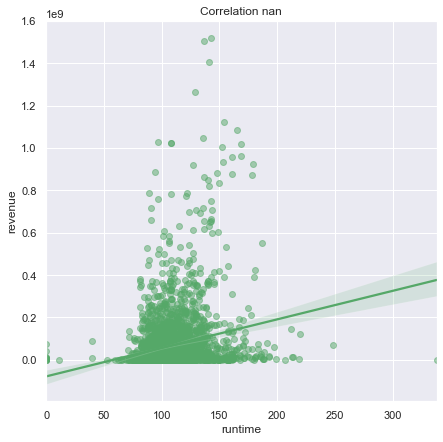

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
colors = sns.color_palette(n_colors=1)
sns.set(color_codes=True)

sns.regplot(x=train_data['runtime'], y=train_data['revenue'], color='g', scatter_kws={'alpha': 0.5})
correlation = np.corrcoef(train_data['runtime'], train_data['revenue'])[0,1]
ax.set_title("Correlation {:.2f}".format(correlation))

Now, let's try to summarize the distributions between each pair of the numerical features in a concise form:

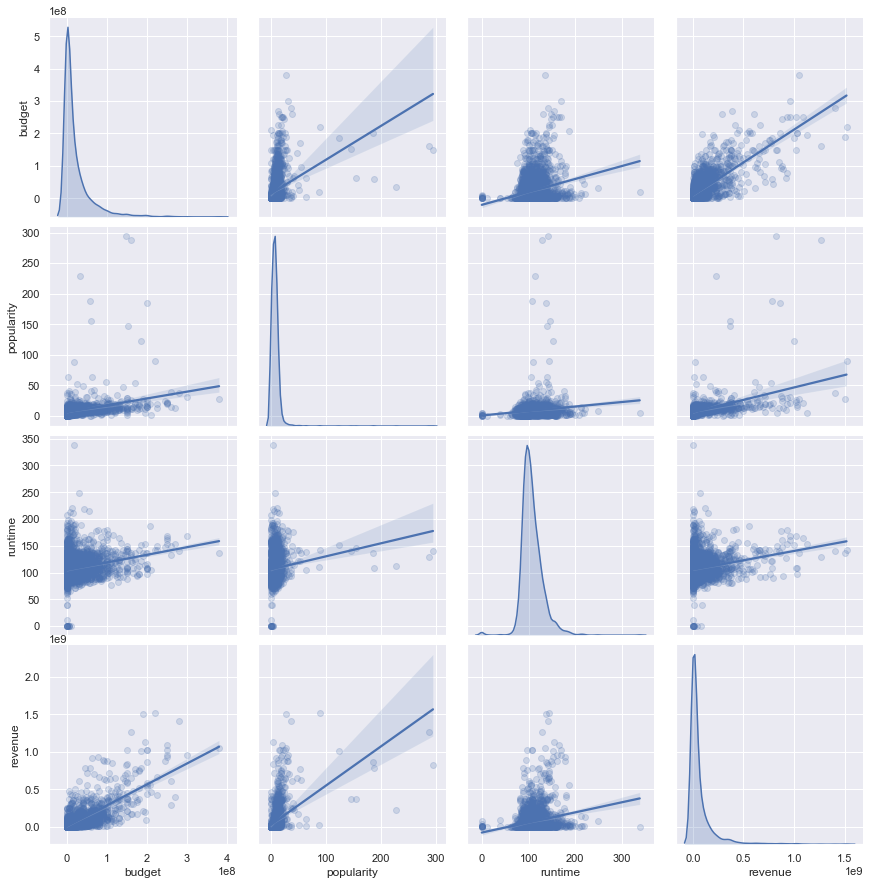

In [10]:
features = ['budget', 'popularity', 'runtime', 'revenue']
sns.pairplot(train_data[features], kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.2}}, size=3)
plt.show()

## Categorical features

In [11]:
# Find categorical features
train_data.select_dtypes(include=['object']).columns.values

array(['belongs_to_collection', 'genres', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew'], dtype=object)

In [12]:
print("There are %i categorical features in total." % len(train_data.select_dtypes(include=['object']).columns.values))

There are 18 categorical features in total.


Let's examine a few categorical features one-by-one.

In [13]:
# belongs_to_collection
percentage_missing = train_data['belongs_to_collection'].isnull().sum() / train_data.shape[0] * 100
print('%.2f percent of belongs_to_collection values are missing.' % percentage_missing)

79.87 percent of belongs_to_collection values are missing.


In [14]:
# release_date
train_data['release_date']

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
          ...   
2995     4/22/94
2996     3/28/13
2997    10/11/96
2998     1/16/04
2999     9/22/11
Name: release_date, Length: 3000, dtype: object

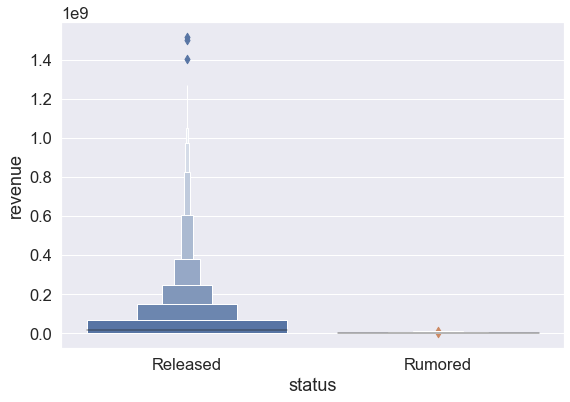

In [15]:
# Status
fig = plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.boxenplot(train_data['status'], train_data['revenue'])
plt.show()

Seems that movies with status 'Rumored' have very small revenues. Let's see what those movies are.

In [16]:
train_data.loc[train_data['status']=='Rumored', ['original_title','overview','release_date','revenue']]

,original_title,overview,release_date,revenue
609,The Swan Princess: Escape from Castle Mountain,The first wedding anniversary of Princess Odet...,1/1/97,273644
1007,Billy Gardell: Halftime,"Billy Gardell, the star of CBS' hit comedy ""Mi...",2/5/11,60
1216,Extremities,A woman escapes from the man who is about to r...,8/22/86,13418091
1618,A Place Called Chiapas,"On January 1, 1994, the Zapatista National Lib...",2/20/98,229000


As the categorical features are quite messy, and there are many missing values, maybe we should first try to fill those missing values and transform the features into a form easier to visualize.

# Fill Missing Values

Let's combine the training set and test set so that we can fill missing values alltogether.

In [17]:
train_size = len(train_data)
all_data = pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True).drop(labels=['id'], axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 22 columns):
Keywords                 6729 non-null object
belongs_to_collection    1481 non-null object
budget                   7398 non-null int64
cast                     7372 non-null object
crew                     7360 non-null object
genres                   7375 non-null object
homepage                 2366 non-null object
imdb_id                  7398 non-null object
original_language        7398 non-null object
original_title           7398 non-null object
overview                 7376 non-null object
popularity               7398 non-null float64
poster_path              7396 non-null object
production_companies     6984 non-null object
production_countries     7241 non-null object
release_date             7397 non-null object
revenue                  3000 non-null float64
runtime                  7392 non-null float64
spoken_languages         7336 non-null object
status           

In [18]:
all_data = all_data.fillna(np.nan)
missing_features = all_data.columns[all_data.isnull().any()]
missing_features.values

array(['Keywords', 'belongs_to_collection', 'cast', 'crew', 'genres',
       'homepage', 'overview', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title'], dtype=object)

Let's see how many values are missing for each feature:

In [19]:
all_data[missing_features].isnull().sum()

Keywords                  669
belongs_to_collection    5917
cast                       26
crew                       38
genres                     23
                         ... 
runtime                     6
spoken_languages           62
status                      2
tagline                  1460
title                       3
Length: 17, dtype: int64

## Treat belongs_to_collection
Let's extract only the collection names.

In [20]:
# We extract collection name like this:
ast.literal_eval(all_data['belongs_to_collection'][1])[0]['name']

'The Princess Diaries Collection'

In [21]:
all_data['collection_name'] = all_data['belongs_to_collection'].apply(lambda x: 'None' if pd.isnull(x) else ast.literal_eval(x)[0]['name'])
all_data['collection_name']

0       Hot Tub Time Machine Collection
1       The Princess Diaries Collection
2                                  None
3                                  None
4                                  None
                     ...               
7393                               None
7394        Without a Paddle Collection
7395                               None
7396                               None
7397                               None
Name: collection_name, Length: 7398, dtype: object

Now we are able to see what the collection names are:

In [22]:
all_data['collection_name'].describe()

count     7398
unique     751
top       None
freq      5917
Name: collection_name, dtype: object

There are 751 unique collections! Let's what the top collections are!

In [23]:
all_data['collection_name'].value_counts().head(10)

None                                      5917
James Bond Collection                       26
Friday the 13th Collection                  12
Pokémon Collection                           9
Star Wars Collection                         8
Halloween Collection                         8
The Pink Panther (Original) Collection       8
The Fast and the Furious Collection          8
Harry Potter Collection                      8
A Nightmare on Elm Street Collection         8
Name: collection_name, dtype: int64

As there are many unique collections, and each collection are fairly small, we instead just indicate if a movie belongs to a collection or not. 

In [24]:
all_data['in_collection'] = all_data['belongs_to_collection'].apply(lambda x: 'No' if pd.isnull(x) else 'Yes')

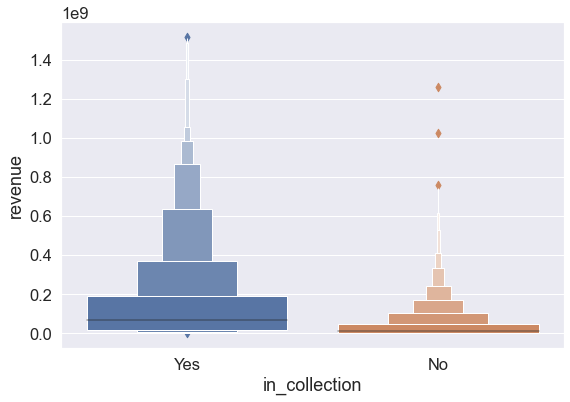

In [25]:
fig = plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.boxenplot(all_data['in_collection'], all_data['revenue'])
plt.show()

Seems that movies that belong to some collection tend to have higher revenues!

## Treat genres

In [26]:
# Extract genres
data_genres = all_data['genres'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).map(lambda x: ','.join(map(str, x)))
data_genres

0                                 Comedy
1            Comedy,Drama,Family,Romance
2                                  Drama
3                         Drama,Thriller
4                        Action,Thriller
                      ...               
7393                            Thriller
7394    Action,Adventure,Comedy,Thriller
7395                               Drama
7396                     Horror,Thriller
7397                               Drama
Name: genres, Length: 7398, dtype: object

In [27]:
data_genres = data_genres.str.get_dummies(sep=',')
data_genres

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7394,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7395,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7396,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [28]:
number_genres = data_genres.sum(axis=1)

In [29]:
genres_sorted = data_genres.sum(axis=0).sort_values(ascending=False)

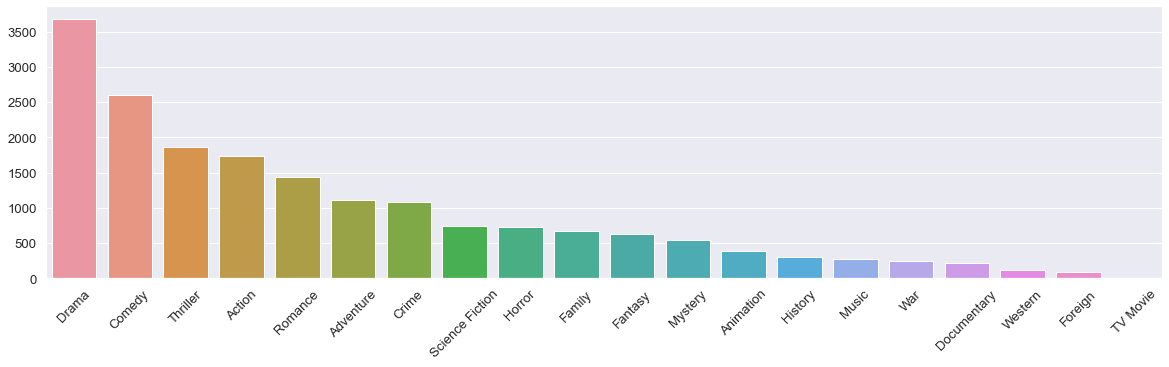

In [30]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(genres_sorted.index, genres_sorted.values)
plt.xticks(rotation=45)
plt.show()

Let's visualize the genres in a wordcloud:

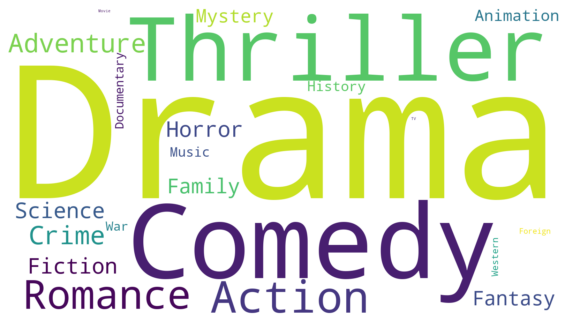

In [31]:
plt.figure(figsize = (10, 6))
temp_genres = all_data['genres'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y))))
text = ' '.join([val for sublist in temp_genres for val in sublist])
wd = WordCloud(max_font_size=1000, background_color='white', collocations=False, width=1600, height=900).generate(text)

# Display the wordcloud
plt.imshow(wd, interpolation='bilinear')
plt.axis("off")
plt.show()

Now we would just include the movie genres as they all have counts greater than 15.

In [32]:
all_data = pd.concat([all_data, data_genres], axis=1, sort=False)
all_data['number_genres'] = number_genres

## Treat production_companies

In [33]:
all_data['production_companies'][0]

"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]"

In [34]:
data_companies = all_data['production_companies'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).map(lambda x: ','.join(map(str, x)))
data_companies

0       Metro-Goldwyn-Mayer (MGM),Paramount Pictures,U...
1                                    Walt Disney Pictures
2       Blumhouse Productions,Bold Films,Right of Way ...
3                                                        
4                                                        
                              ...                        
7393    DiNovi Pictures,Epsilon Motion Pictures,Hyde P...
7394                  De Line Pictures,Paramount Pictures
7395               Twentieth Century Fox Film Corporation
7396      Animal Kingdom,Northern Lights Films,Two Flints
7397    Les Films de la Pléiade,Pathé Consortium Ciném...
Name: production_companies, Length: 7398, dtype: object

In [35]:
data_companies[7393]

'DiNovi Pictures,Epsilon Motion Pictures,Hyde Park Entertainment,Intermedia Films,Metro-Goldwyn-Mayer (MGM),UGC DA International,Via Rosa Productions'

In [36]:
data_companies = data_companies.str.get_dummies(sep=',')

In [37]:
number_companies = data_companies.sum(axis=1)
number_companies

0       3
1       1
2       3
3       0
4       0
       ..
7393    7
7394    2
7395    1
7396    3
7397    3
Length: 7398, dtype: int64

In [38]:
data_companies.sum(axis=0).sort_values(ascending=False).head(15)

Warner Bros.                              491
Universal Pictures                        463
Paramount Pictures                        393
Twentieth Century Fox Film Corporation    341
Columbia Pictures                         236
                                         ... 
Canal+                                    130
TriStar Pictures                          121
Relativity Media                          115
United Artists                            105
Miramax Films                             104
Length: 15, dtype: int64

In [39]:
data_companies = data_companies[data_companies.sum(axis=0).sort_values(ascending=False).head(15).index.values]

In [40]:
all_data = pd.concat([all_data, data_companies], axis=1, sort=False)
all_data['number_companies'] = number_companies

## Treat production_countries

In [41]:
all_data['production_countries'][6]

"[{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]"

In [42]:
data_countries = all_data['production_countries'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).map(lambda x: ','.join(map(str, x)))
data_countries

0              United States of America
1              United States of America
2              United States of America
3                                 India
4                           South Korea
                     ...               
7393    France,United States of America
7394           United States of America
7395           United States of America
7396           United States of America
7397                             France
Name: production_countries, Length: 7398, dtype: object

In [43]:
data_countries = data_countries.str.get_dummies(sep=',')

In [44]:
data_countries.sum(axis=0).sort_values(ascending=False).head(16)

United States of America    5617
United Kingdom               917
France                       570
Germany                      411
Canada                       323
                            ... 
China                         99
Hong Kong                     96
Belgium                       64
Ireland                       62
South Korea                   58
Length: 16, dtype: int64

Right now let's include only the top 4 countries.

In [45]:
data_countries = data_countries[data_countries.sum(axis=0).sort_values(ascending=False).head(16).index.values]
data_countries

,United States of America,United Kingdom,France,Germany,Canada,India,Italy,Japan,Australia,Spain,Russia,China,Hong Kong,Belgium,Ireland,South Korea
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7394,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7395,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7396,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
all_data = pd.concat([all_data, data_countries], axis=1, sort=False)

## Treat spoken_languages

In [47]:
data_language = all_data['spoken_languages'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).map(lambda x: ','.join(map(str, x)))
data_language

0                                 English
1                                 English
2                                 English
3                          English,हिन्दी
4                                 한국어/조선말
                      ...                
7393    Deutsch,English,Español,Latin,日本語
7394                              English
7395                              English
7396                              English
7397                             Français
Name: spoken_languages, Length: 7398, dtype: object

In [48]:
data_language = data_language.str.get_dummies(sep=',')

In [49]:
data_language.sum(axis=0).sort_values(ascending=False).head(20)

English     6449
Français     711
Español      559
Deutsch      419
Pусский      364
            ... 
Magyar        64
Český         57
ภาษาไทย       55
தமிழ்         52
svenska       50
Length: 20, dtype: int64

In [50]:
data_language = data_language[data_language.sum(axis=0).sort_values(ascending=False).head(20).index.values]
data_language

,English,Français,Español,Deutsch,Pусский,Italiano,日本語,普通话,हिन्दी,العربية,Português,广州话 / 廣州話,한국어/조선말,Polski,Latin,Magyar,Český,ภาษาไทย,தமிழ்,svenska
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
7394,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7395,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7396,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
all_data = pd.concat([all_data, data_language], axis=1, sort=False)

## Treat status

In [52]:
Counter(all_data['status'])

Counter({'Released': 7385, 'Rumored': 6, 'Post Production': 5, nan: 2})

In [53]:
all_data.loc[all_data['status'].isnull(), 'status'] = 'Released'

In [54]:
Counter(all_data['status'])

Counter({'Released': 7387, 'Rumored': 6, 'Post Production': 5})

## Treat tagline

In [55]:
all_data['tagline'] = all_data['tagline'].apply(lambda x: 'no tagline' if pd.isnull(x) else 'has tagline')
all_data['tagline']

0       has tagline
1       has tagline
2       has tagline
3        no tagline
4        no tagline
           ...     
7393    has tagline
7394    has tagline
7395    has tagline
7396    has tagline
7397    has tagline
Name: tagline, Length: 7398, dtype: object

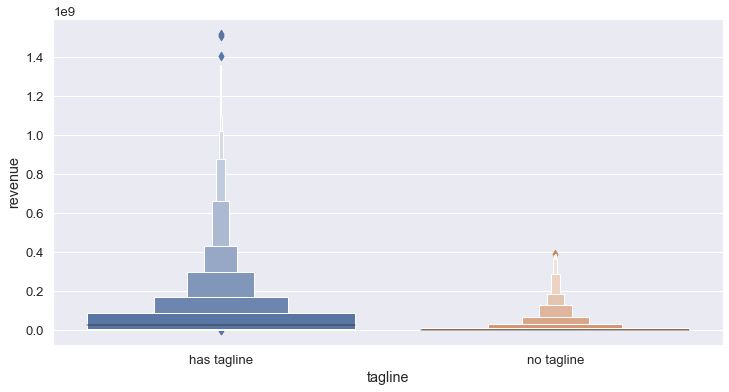

In [56]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxenplot(all_data['tagline'], all_data['revenue'])
plt.show()

## Treat keywords

In [57]:
all_data['Keywords'][100]

"[{'id': 2620, 'name': 'evidence'}, {'id': 2635, 'name': 'overdose'}, {'id': 2671, 'name': 'heroin'}, {'id': 8015, 'name': 'cop'}, {'id': 9951, 'name': 'alien'}, {'id': 10950, 'name': 'shootout'}, {'id': 11199, 'name': 'undercover cop'}, {'id': 14964, 'name': 'drug'}]"

In [58]:
data_keywords = all_data['Keywords'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).map(lambda x: ','.join(map(str, x)))
data_keywords

0         duringcreditsstinger,hot tub,sequel,time travel
1                coronation,duty,falling in love,marriage
2       conservatory,drummer,jazz,jazz band,montage,mu...
3       bollywood,crime,india,missing husband,mystery,...
4                                                        
                              ...                        
7393    coffee grower,cuba,denunciation,eroticism,love...
7394                      death of a friend,treasure hunt
7395    alcoholic,boston,court,courtroom,defense attor...
7396    chase,followed,friends,school,supernatural,vis...
7397    female protagonist,free will,paris,philosophy,...
Name: Keywords, Length: 7398, dtype: object

In [59]:
# Number of keywords
data_keywords[0]

'duringcreditsstinger,hot tub,sequel,time travel'

In [60]:
data_keywords = data_keywords.str.get_dummies(sep=',')
data_keywords

,co,england,new york city,pa,1500s,15th century,16th century,17th century,18th century,1910s,...,strange noise,wichita kansas,ÁªùÂú∞Â•∂Èú∏,ÂçßÂ∫ïËÇ•Â¶à,Ë∂ÖÁ∫ßÂ¶àÂ¶à,ŒìŒ∑,–ª—é–±–æ–≤—å,–±–∏—Ç–≤–∞,–≤–æ–∏–Ω,√òverste hylde
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
number_keywords = data_keywords.sum(axis=1)

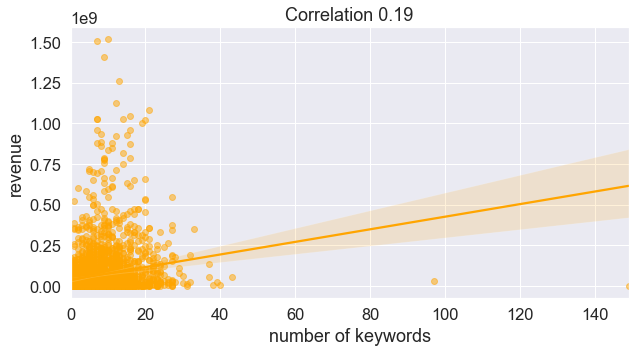

In [62]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(x=number_keywords[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='orange')
correlation = np.corrcoef(number_keywords[:3000], train_data['revenue'])[0,1]
ax.set_xlabel("number of keywords")
ax.set_title("Correlation {:.2f}".format(correlation))
plt.show()

In [63]:
data_keywords.sum(axis=0).sort_values(ascending=False).head(30)

woman director          457
independent film        384
duringcreditsstinger    350
based on novel          312
murder                  305
                       ... 
3d                      113
family                  111
high school             111
alien                   100
world war ii             98
Length: 30, dtype: int64

We include the top 9 keywords.

In [64]:
data_keywords = data_keywords[data_keywords.sum(axis=0).sort_values(ascending=False).head(30).index.values]
data_keywords

,woman director,independent film,duringcreditsstinger,based on novel,murder,violence,love,revenge,sex,aftercreditsstinger,...,female nudity,drug,los angeles,new york,prison,3d,family,high school,alien,world war ii
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
all_data = pd.concat([all_data, data_keywords], axis=1, sort=False)
all_data['number_keywords'] = number_keywords

## Treat homepage

In [66]:
all_data['homepage'] = all_data['homepage'].apply(lambda x: 'no homepage' if pd.isnull(x) else 'has homepage')

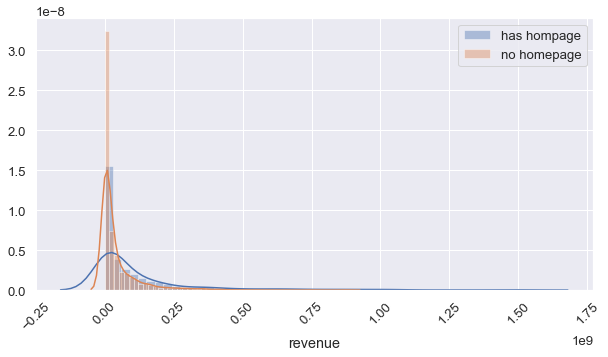

In [67]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(all_data[:3000].loc[all_data['homepage']=='has homepage', 'revenue'])
sns.distplot(all_data[:3000].loc[all_data['homepage']=='no homepage', 'revenue'])
plt.legend(['has hompage', 'no homepage'])
plt.xticks(rotation=45)
plt.show()

## Treat original_language

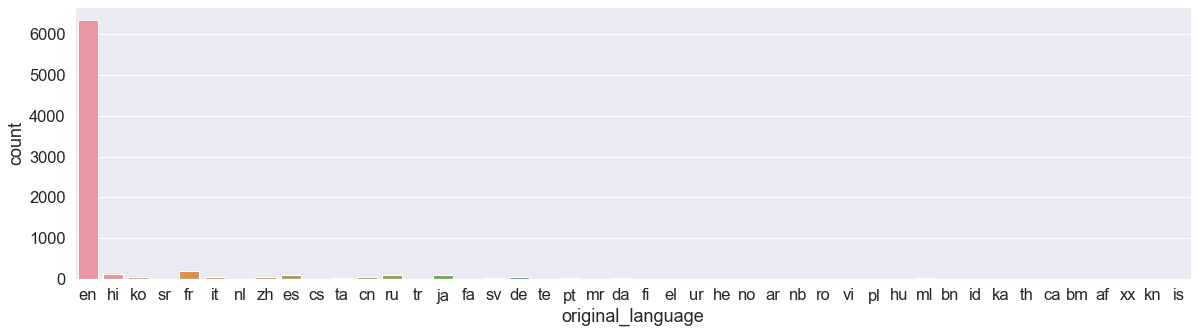

In [68]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(all_data['original_language'])
plt.show()

Most are in English language, so we just distinguish between English and non-English.

In [69]:
all_data['in_English'] = all_data['original_language'].apply(lambda x: 'Yes' if x=='en' else 'No')

## Treat runtime

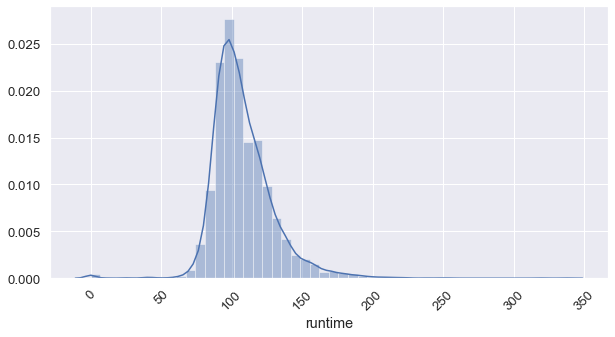

In [70]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(all_data['runtime'])
plt.xticks(rotation=45)
plt.show()

In [71]:
all_data.loc[all_data['runtime'].isnull(), 'runtime'] = all_data['runtime'].mode().values[0]

## Treat cast

In [72]:
all_data['cast'][4]

"[{'cast_id': 3, 'character': 'Chun-soo', 'credit_id': '52fe464b9251416c75073b47', 'gender': 2, 'id': 84751, 'name': 'Kim Kang-woo', 'order': 0, 'profile_path': '/lJvcgUx1qEnNfGcCtbmp3EC5vCG.jpg'}, {'cast_id': 4, 'character': 'Company president Kang', 'credit_id': '52fe464b9251416c75073b4b', 'gender': 2, 'id': 64453, 'name': 'Jo Jae-hyeon', 'order': 1, 'profile_path': '/2QVUP8t3zmKcwlm7IBOzPVikKe7.jpg'}, {'cast_id': 5, 'character': 'Yu-ri', 'credit_id': '52fe464b9251416c75073b4f', 'gender': 2, 'id': 84752, 'name': 'Park Si-yeon', 'order': 2, 'profile_path': '/pIWhmT2GTVcaNTb6Qta2KS9jyTT.jpg'}, {'cast_id': 7, 'character': 'Company president Hwang', 'credit_id': '52fe464b9251416c75073b59', 'gender': 2, 'id': 1130534, 'name': 'Kim Joon-bae', 'order': 3, 'profile_path': '/pMy3HSxj6DdysI1P2tpjcD4FyWM.jpg'}]"

In [73]:
cast_size = all_data['cast'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).apply(lambda x: len(x))
cast_size

0       24
1       20
2       51
3        7
4        4
        ..
7393    10
7394    22
7395    17
7396    29
7397    19
Name: cast, Length: 7398, dtype: int64

In [74]:
# Cast gender
cast_gender = all_data['cast'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['gender'], eval(y))))
cast_gender

0       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...
1       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3                                   [0, 0, 0, 0, 1, 2, 2]
4                                            [2, 2, 2, 2]
                              ...                        
7393                       [1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
7394    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, ...
7395    [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
7396    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...
7397    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: cast, Length: 7398, dtype: object

In [75]:
# Count each gender
cast_female_count = cast_gender.apply(lambda x: (pd.Series(x)==1).sum())
cast_male_count = cast_gender.apply(lambda x: (pd.Series(x)==2).sum())

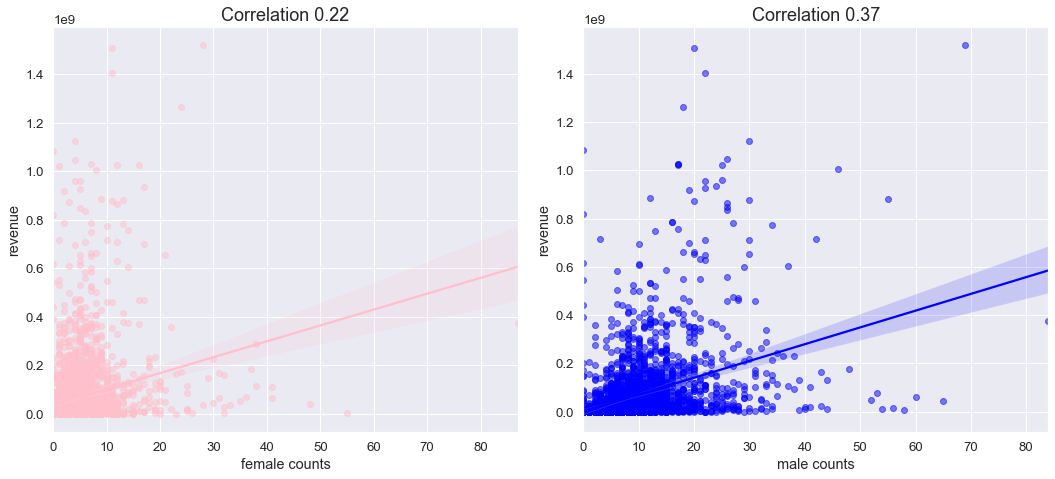

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set(color_codes=True, font_scale=1.5)

sns.regplot(x=cast_female_count[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='pink', ax=axes[0])
correlation = np.corrcoef(cast_female_count[:3000], train_data['revenue'])[0,1]
axes[0].set_xlabel("female counts")
axes[0].set_title("Correlation {:.2f}".format(correlation))

sns.regplot(x=cast_male_count[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='blue', ax=axes[1])
correlation = np.corrcoef(cast_male_count[:3000], train_data['revenue'])[0,1]
axes[1].set_xlabel("male counts")
axes[1].set_title("Correlation {:.2f}".format(correlation))

plt.tight_layout()
plt.show()

Let's see if there is some correlation between cast size and revenue, in the training data.

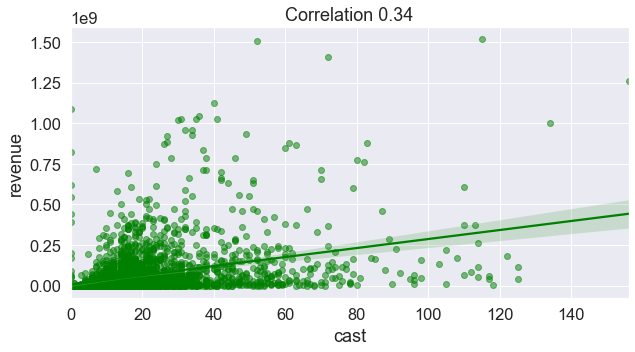

In [77]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(x=cast_size[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='green')
correlation = np.corrcoef(cast_size[:3000], train_data['revenue'])[0,1]
ax.set_title("Correlation {:.2f}".format(correlation))
plt.show()

There is small to moderate positive correlation between cast size and revenue, so let's include the cast size!

In [78]:
all_data['cast_size'] = cast_size
all_data['cast_male_count'] = cast_male_count
all_data['cast_female_count'] = cast_female_count

## Treat crew
Similarly to cast, we can invastigate the crew size and see if there's an impact on the revenue.

In [79]:
crew_size = all_data['crew'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['name'], eval(y)))).apply(lambda x: len(x))
crew_size

0       72
1        9
2       64
3        3
4        2
        ..
7393    11
7394    94
7395    12
7396    29
7397    25
Name: crew, Length: 7398, dtype: int64

In [80]:
# Crew gender
crew_gender = all_data['crew'].apply(lambda y: {} if pd.isnull(y) else sorted(map(lambda x: x['gender'], eval(y))))
crew_gender

0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1                             [0, 1, 1, 1, 1, 2, 2, 2, 2]
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3                                               [0, 0, 0]
4                                                  [0, 0]
                              ...                        
7393                    [0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
7394    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7395                 [0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
7396    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7397    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: crew, Length: 7398, dtype: object

In [81]:
# Count each gender
crew_female_count = crew_gender.apply(lambda x: (pd.Series(x)==1).sum())
crew_male_count = crew_gender.apply(lambda x: (pd.Series(x)==2).sum())

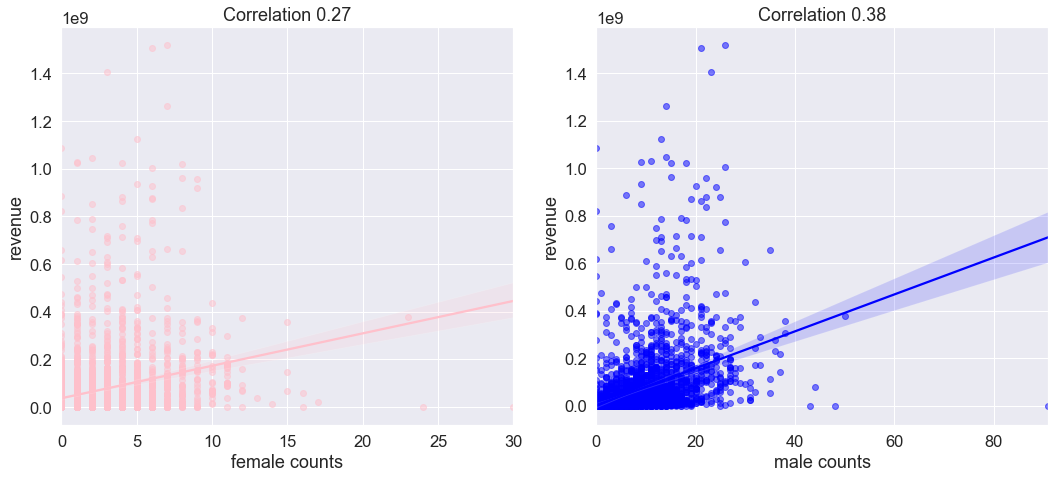

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set(color_codes=True, font_scale=1.5)

sns.regplot(x=crew_female_count[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='pink', ax=axes[0])
correlation = np.corrcoef(crew_female_count[:3000], train_data['revenue'])[0,1]
axes[0].set_xlabel("female counts")
axes[0].set_title("Correlation {:.2f}".format(correlation))

sns.regplot(x=crew_male_count[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='blue', ax=axes[1])
correlation = np.corrcoef(crew_male_count[:3000], train_data['revenue'])[0,1]
axes[1].set_xlabel("male counts")
axes[1].set_title("Correlation {:.2f}".format(correlation))

plt.tight_layout()
plt.show()

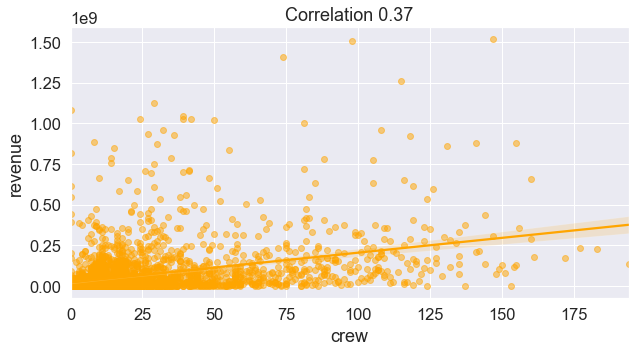

In [83]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(x=crew_size[:3000], y=train_data['revenue'], scatter_kws={'alpha':0.5}, color='orange')
correlation = np.corrcoef(crew_size[:3000], train_data['revenue'])[0,1]
ax.set_title("Correlation {:.2f}".format(correlation))
plt.show()

In [84]:
all_data['crew_size'] = crew_size
all_data['crew_male_count'] = crew_male_count
all_data['crew_female_count'] = crew_female_count

## Treat release_date
This is the last one to fill the missing values! Yay!

In [85]:
all_data.loc[all_data['release_date'].isnull(), 'release_date']

3828    NaN
Name: release_date, dtype: object

In [86]:
all_data.loc[all_data['release_date'].isnull(), 'release_date'] = '3/20/2001'

In [87]:
all_data.loc[all_data['release_date'].isnull(), 'release_date']

Series([], Name: release_date, dtype: object)

## Final check

Now Let's confirm that all missing values are filled.

In [88]:
# Drop the unnecessary features
all_data = all_data.drop(labels=['belongs_to_collection','collection_name','genres','production_companies','production_countries','spoken_languages','Keywords','original_language','cast','crew'], axis=1)

In [89]:
all_data = all_data.drop(labels=['overview','poster_path','title'], axis=1)

In [90]:
all_data = all_data.drop(labels=['imdb_id','original_title'], axis=1)

In [91]:
all_data.columns[all_data.isnull().any()]

Index(['revenue'], dtype='object')

Nice, all the missing values are filled, except the ones in the revenue that we are going to predict. Now, let's see what the features do we have now:

In [92]:
all_data.columns.values

array(['budget', 'homepage', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'tagline', 'in_collection', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'number_genres', 'Warner Bros.',
       'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema',
       'Touchstone Pictures', 'Walt Disney Pictures',
       'Columbia Pictures Corporation', 'Canal+', 'TriStar Pictures',
       'Relativity Media', 'United Artists', 'Miramax Films',
       'number_companies', 'United States of America', 'United Kingdom',
       'France', 'Germany', 'Canada', 'India', 'Italy', 'Japan',
       'Australia', 'Spain', 'Russia', 'China', 'Hong Kong', 'Belgium',
       'Ireland',

# Feature Engineering
**In this section, we are going to transform the features into a form that we can easily apply some machine learning models. To do this, we need to transform the categorical features into dummy variables, and maybe appy log-transforms to some numerical features. Notice that in the previous section, when we are filling the missing values, we also did some feature engineering as we generated many dummy variables from genres, keywords, etc.**

## Engineer release_date
**It might be interesting to see how the year, month, week of the release date affect the revenue!**

In [93]:
data_date = all_data.release_date.apply(lambda x: x.split('/'))
data_month = data_date.apply(lambda x: x[0]).apply(int)
data_day = data_date.apply(lambda x: x[1]).apply(int)
data_year = data_date.apply(lambda x: x[2]).apply(int)

In [94]:
data_month.name = 'month'
data_day.name = 'day'
data_year.name = 'year'

### Year

In [95]:
data_year.loc[data_year==2001] = 1

In [96]:
data_year = data_year.apply(lambda x: x+2000 if x<=20 else x+1900)

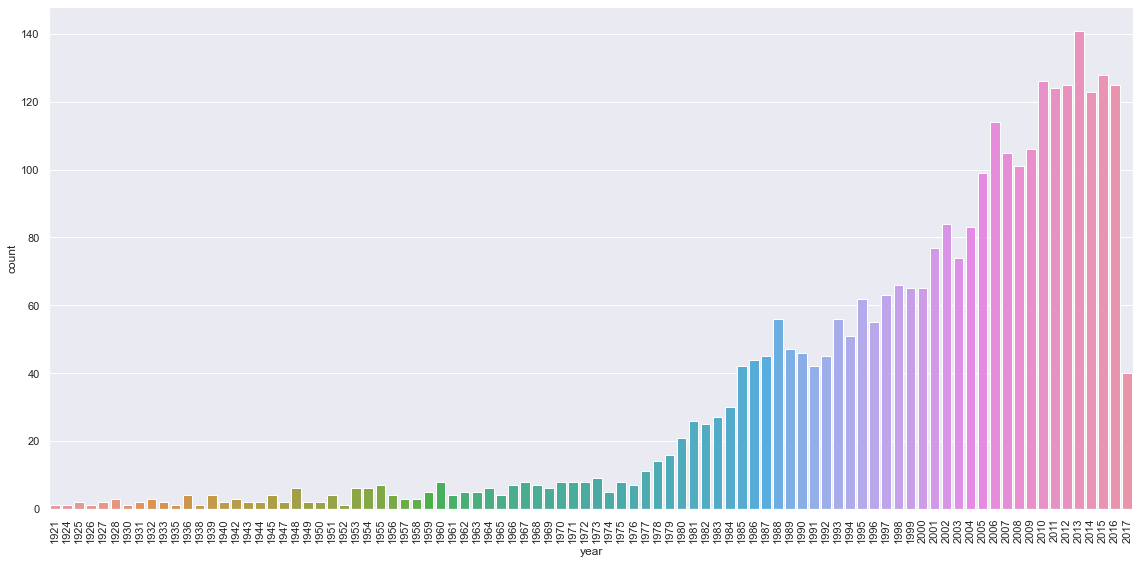

In [97]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(data_year[:3000])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Let's see how the year correlate with the revenue:

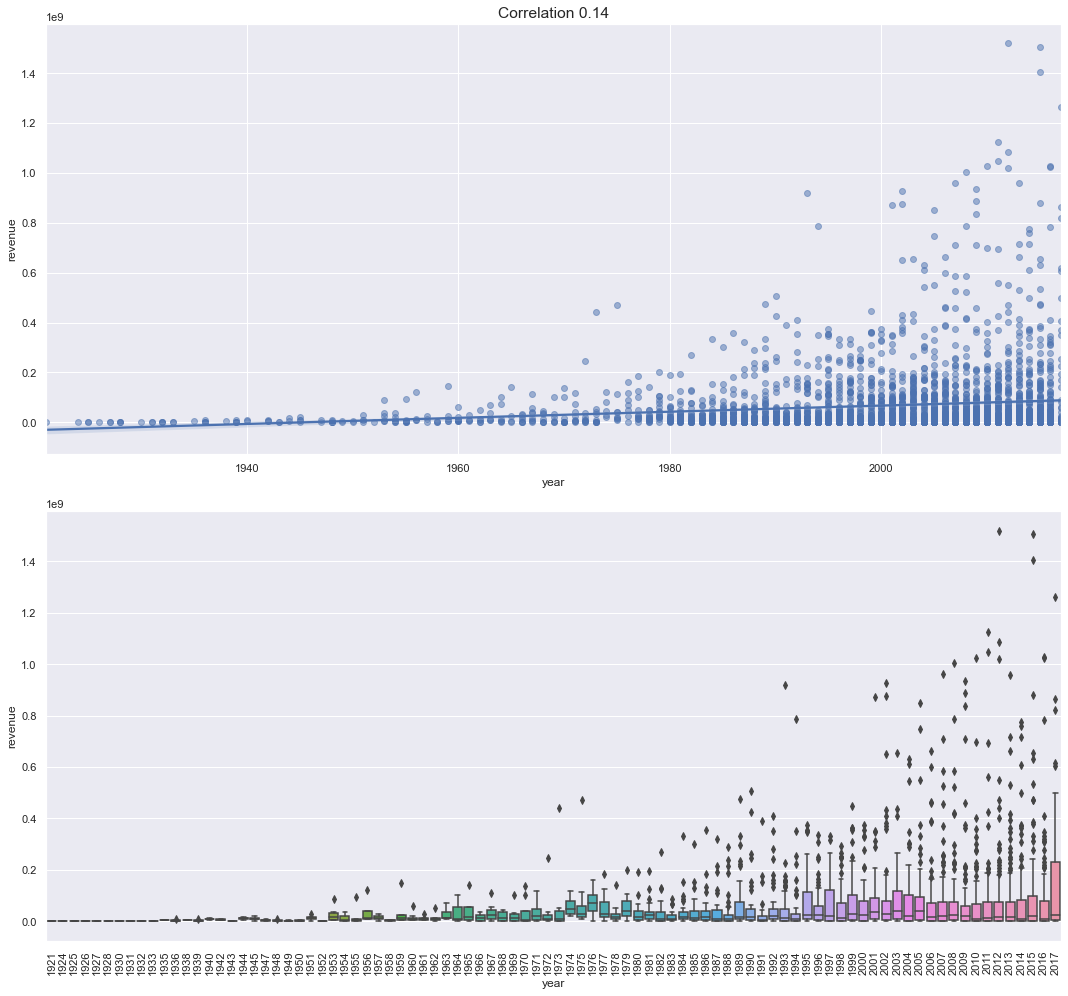

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,14))
sns.set(color_codes=True, font_scale=1.3)

sns.regplot(data_year[:3000], all_data['revenue'][:3000], scatter_kws={'alpha': 0.5}, ax=axes[0])
correlation = np.corrcoef(data_year[:3000], train_data['revenue'][:3000])[0,1]
axes[0].set_title("Correlation {:.2f}".format(correlation))

sns.set(font_scale=1)
sns.boxplot(data_year[:3000], all_data['revenue'][:3000], ax=axes[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

It seems that the revenue increases with year, we can include the year as a numerical feature.

In [99]:
# Include data_year in our dataset
all_data = pd.concat([all_data, data_year], axis=1, sort=False)
# all_data['year'] = data_year

In [100]:
# all_data.groupby("year")["revenue"].aggregate('mean').plot()

### Month

In [101]:
temp_data = pd.concat([all_data, data_month], axis=1, sort=False)
month_median = temp_data.groupby('month')['revenue'].median()
month_mean = temp_data.groupby('month')['revenue'].mean()

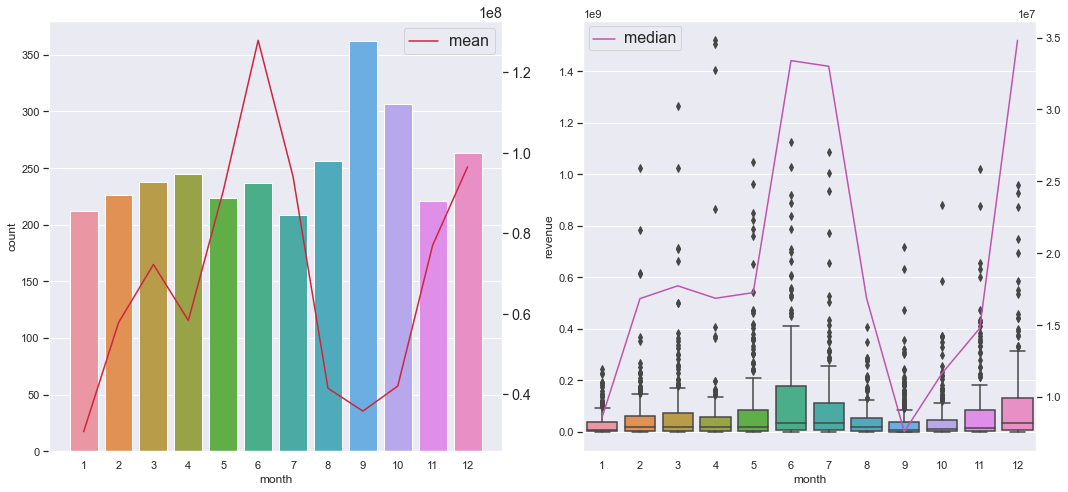

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set(color_codes=True, font_scale=1.3)

sns.countplot(data_month[:3000], order=[1,2,3,4,5,6,7,8,9,10,11,12], ax=axes[0])
ax02 = axes[0].twinx()
ax02.grid(False)
g = sns.lineplot(month_mean.index.values-1, month_mean.values, color='#D0233C', label='mean')
plt.setp(g.get_legend().get_texts(), fontsize='16')

sns.set(font_scale=1)
sns.boxplot(data_month[:3000], all_data['revenue'][:3000], ax=axes[1])
ax12 = axes[1].twinx()
ax12.grid(False)
g = sns.lineplot(month_median.index.values-1, month_median.values, color='#C053AC', label='median')
plt.setp(g.get_legend().get_texts(), fontsize='16')

plt.tight_layout()
plt.show()

Movies released in June, July, or December tend to have higher revenues, we can identify those months in our dataset.

In [103]:
data_month_transformed = pd.get_dummies(data_month)

In [104]:
data_month_transformed.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [105]:
all_data = pd.concat([all_data, data_month_transformed], axis=1)

### Day

In [106]:
data_date = pd.concat([data_month, data_day, data_year], axis=1).apply(lambda x: "/".join([str(x.month), str(x.day), str(x.year)]), axis=1)
data_weekday = data_date.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').weekday())
data_weekday = data_weekday.replace({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})

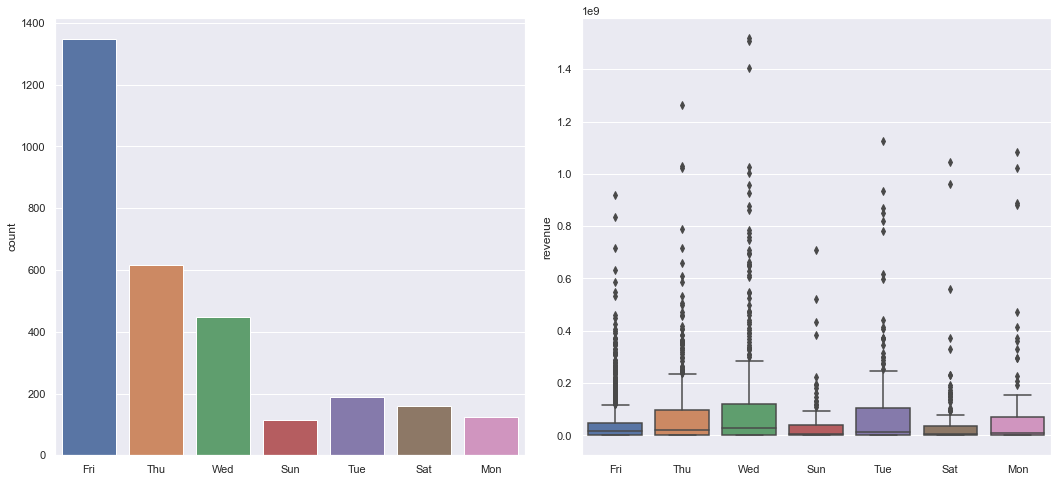

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set(color_codes=True, font_scale=1.4)

sns.countplot(data_weekday[:3000], ax=axes[0])
sns.boxplot(data_weekday[:3000], all_data['revenue'][:3000], ax=axes[1])
# plt.xticks(rotation=0, fontsize=16)

plt.tight_layout()
plt.show()

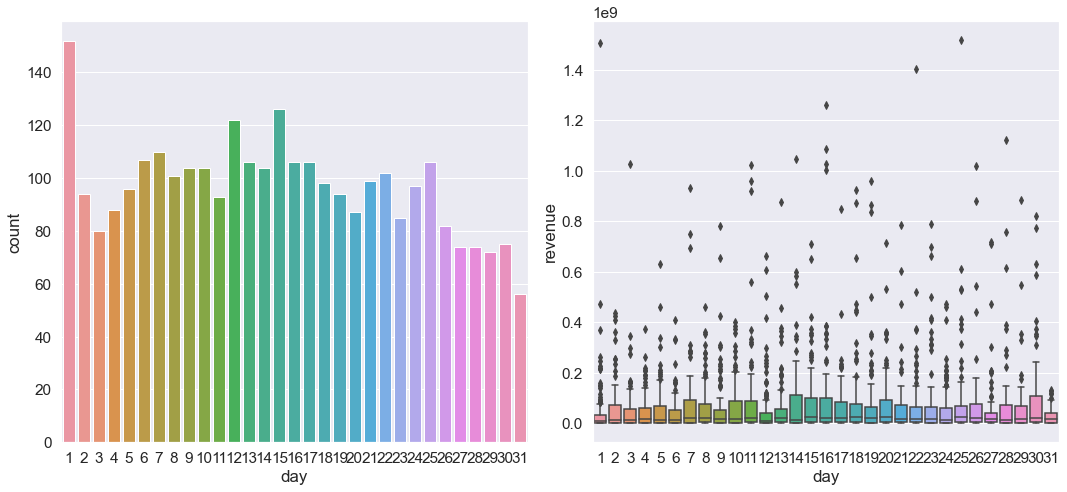

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set(color_codes=True, font_scale=1)

sns.countplot(data_day[:3000], ax=axes[0])
sns.boxplot(data_day[:3000], all_data['revenue'][:3000], ax=axes[1])
# plt.xticks(rotation=0, fontsize=16)

plt.tight_layout()
plt.show()

In [109]:
data_weekday.name = 'weekday'
temp_data = pd.concat([train_data['revenue'], data_weekday[:3000]], axis=1, sort=False)
weekday_median = temp_data.groupby('weekday')['revenue'].median()
weekday_mean = temp_data.groupby('weekday')['revenue'].mean()

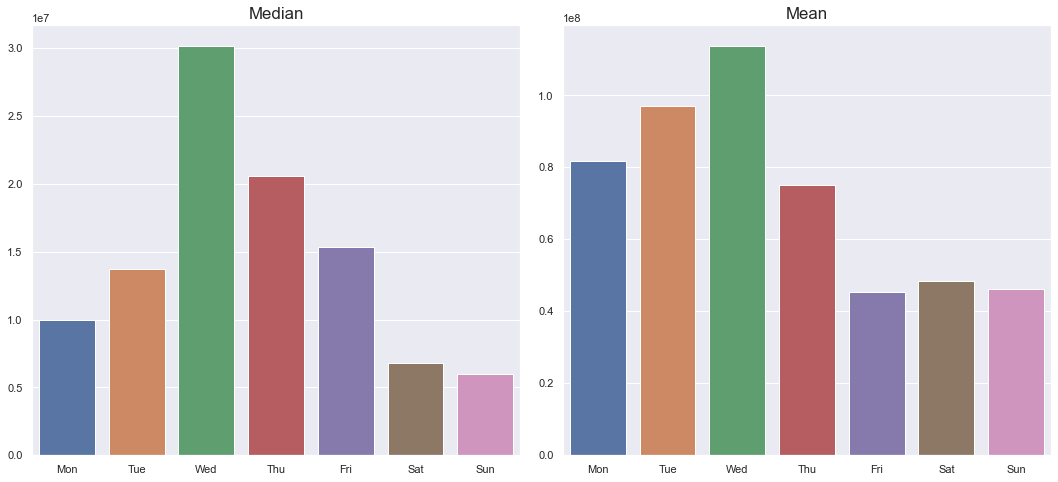

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set(color_codes=True, font_scale=1.4)

g1 = sns.barplot(weekday_median.index.values, weekday_median.values, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], ax=axes[0], label='median')
g2 = sns.barplot(weekday_mean.index.values, weekday_mean.values, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], ax=axes[1], label='mean')
axes[0].set_title("Median")
axes[1].set_title("Mean")

plt.tight_layout()
plt.show()

Movies released on Wednesdays have the highest revenues in terms of median and mean. We can distinguish among the different days in a week.

In [111]:
all_data = pd.concat([all_data, pd.get_dummies(data_weekday)], axis=1)

In [112]:
all_data = all_data.drop(labels=['release_date'], axis=1)

## Categorical features

In [113]:
all_data.select_dtypes('object').head()

,homepage,status,tagline,in_collection,in_English
0,no homepage,Released,has tagline,Yes,Yes
1,no homepage,Released,has tagline,Yes,Yes
2,has homepage,Released,has tagline,No,Yes
3,has homepage,Released,no tagline,No,No
4,no homepage,Released,no tagline,No,No


In [114]:
all_data = pd.concat([all_data, pd.get_dummies(all_data.select_dtypes('object'), columns=['homepage','status','tagline','in_collection','in_English'], drop_first=True)], axis=1)

In [115]:
all_data = all_data.drop(labels=['homepage','status','tagline','in_collection','in_English'], axis=1)
all_data.columns.values

array(['budget', 'popularity', 'revenue', 'runtime', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'number_genres', 'Warner Bros.',
       'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema',
       'Touchstone Pictures', 'Walt Disney Pictures',
       'Columbia Pictures Corporation', 'Canal+', 'TriStar Pictures',
       'Relativity Media', 'United Artists', 'Miramax Films',
       'number_companies', 'United States of America', 'United Kingdom',
       'France', 'Germany', 'Canada', 'India', 'Italy', 'Japan',
       'Australia', 'Spain', 'Russia', 'China', 'Hong Kong', 'Belgium',
       'Ireland', 'South Korea', 'English', 'Français', 'Español',
       'Deutsch', 'Pусс

**Good! Now all the features are numerical!**

## Numerical features

### Data cleaning

In [116]:
original_numerical_features = ['budget', 'popularity', 'runtime']

In [117]:
# Fill in movie runtime
train_data.loc[train_data['title'] == 'The Worst Christmas of My Life', 'runtime'] = 87.0
train_data.loc[train_data['title'] == 'А поутру они проснулись', 'runtime'] = 90.0
train_data.loc[train_data['title'] == '¿Quién mató a Bambi?', 'runtime'] = 86.0
train_data.loc[train_data['title'] == 'La peggior settimana della mia vita', 'runtime'] = 93.0
train_data.loc[train_data['title'] == 'Cry, Onion!', 'runtime'] = 92.0
train_data.loc[train_data['title'] == 'All at Once', 'runtime'] = 93.0
train_data.loc[train_data['title'] == 'Missing', 'runtime'] = 86.0
train_data.loc[train_data['title'] == 'Mechenosets', 'runtime'] = 108.0
train_data.loc[train_data['title'] == 'Hooked on the Game 2. The Next Level', 'runtime'] = 86.0
train_data.loc[train_data['title'] == 'My Old Classmate', 'runtime'] = 98.0
train_data.loc[train_data['title'] == 'Revelation', 'runtime'] = 111.0
train_data.loc[train_data['title'] == 'Tutto tutto niente niente', 'runtime'] = 96.0
train_data.loc[train_data['title'] == 'Королёв', 'runtime'] = 130.0
train_data.loc[train_data['title'] == 'Happy Weekend', 'runtime'] = 100.0 # missing, use mode

test_data.loc[test_data['title'] == 'Shikshanachya Aaicha Gho', 'runtime'] = 103.0
test_data.loc[test_data['title'] == 'Street Knight', 'runtime'] = 91.0
test_data.loc[test_data['title'] == 'Plus one', 'runtime'] = 98.0
test_data.loc[test_data['title'] == 'Glukhar v kino', 'runtime'] = 86.0
test_data.loc[test_data['title'] == 'Frau Müller muss weg!', 'runtime'] = 83.0
test_data.loc[test_data['title'] == 'Shabd', 'runtime'] = 140.0
test_data.loc[test_data['title'] == 'The Last Breath', 'runtime'] = 104.0
test_data.loc[test_data['title'] == 'Chaahat Ek Nasha...', 'runtime'] = 140.0
test_data.loc[test_data['title'] == 'El truco del manco', 'runtime'] = 100.0 # The runtime is missing from IMDB!
test_data.loc[test_data['title'] == 'La caliente niña Julietta', 'runtime'] = 93.0
test_data.loc[test_data['title'] == 'Pancho, el perro millonario', 'runtime'] = 91.0
test_data.loc[test_data['title'] == 'Nunca en horas de clase', 'runtime'] = 100.0
test_data.loc[test_data['title'] == 'Miesten välisiä keskusteluja', 'runtime'] = 90.0

In [118]:
# Clearn training set: I used the additional information from this kernel:
# https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat/notebook#Feature-Engineering-&-Prediction
train_data.loc[train_data['id'] == 16,'revenue'] = 192864          # Skinning
train_data.loc[train_data['id'] == 90,'budget'] = 30000000         # Sommersby          
train_data.loc[train_data['id'] == 118,'budget'] = 60000000        # Wild Hogs
train_data.loc[train_data['id'] == 149,'budget'] = 18000000        # Beethoven
train_data.loc[train_data['id'] == 313,'revenue'] = 12000000       # The Cookout 
train_data.loc[train_data['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train_data.loc[train_data['id'] == 464,'budget'] = 20000000        # Parenthood
train_data.loc[train_data['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train_data.loc[train_data['id'] == 513,'budget'] = 930000          # From Prada to Nada
train_data.loc[train_data['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train_data.loc[train_data['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train_data.loc[train_data['id'] == 850,'budget'] = 90000000        # Modern Times
train_data.loc[train_data['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train_data.loc[train_data['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train_data.loc[train_data['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train_data.loc[train_data['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train_data.loc[train_data['id'] == 1542,'budget'] = 1              # All at Once
train_data.loc[train_data['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train_data.loc[train_data['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train_data.loc[train_data['id'] == 1714,'budget'] = 46000000       # The Recruit
train_data.loc[train_data['id'] == 1721,'budget'] = 17500000       # Cocoon
train_data.loc[train_data['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train_data.loc[train_data['id'] == 1885,'budget'] = 12             # In the Cut
train_data.loc[train_data['id'] == 2091,'budget'] = 10             # Deadfall
train_data.loc[train_data['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train_data.loc[train_data['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train_data.loc[train_data['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train_data.loc[train_data['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train_data.loc[train_data['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train_data.loc[train_data['id'] == 2801,'budget'] = 10000000       # Fracture
train_data.loc[train_data['id'] == 335,'budget'] = 2 
train_data.loc[train_data['id'] == 348,'budget'] = 12
train_data.loc[train_data['id'] == 470,'budget'] = 13000000 
train_data.loc[train_data['id'] == 513,'budget'] = 1100000
train_data.loc[train_data['id'] == 640,'budget'] = 6 
train_data.loc[train_data['id'] == 696,'budget'] = 1
train_data.loc[train_data['id'] == 797,'budget'] = 8000000 
train_data.loc[train_data['id'] == 850,'budget'] = 1500000
train_data.loc[train_data['id'] == 1199,'budget'] = 5 
train_data.loc[train_data['id'] == 1282,'budget'] = 9               # Death at a Funeral
train_data.loc[train_data['id'] == 1347,'budget'] = 1
train_data.loc[train_data['id'] == 1755,'budget'] = 2
train_data.loc[train_data['id'] == 1801,'budget'] = 5
train_data.loc[train_data['id'] == 1918,'budget'] = 592 
train_data.loc[train_data['id'] == 2033,'budget'] = 4
train_data.loc[train_data['id'] == 2118,'budget'] = 344 
train_data.loc[train_data['id'] == 2252,'budget'] = 130
train_data.loc[train_data['id'] == 2256,'budget'] = 1 
train_data.loc[train_data['id'] == 2696,'budget'] = 10000000

In [119]:
# Clean test set
test_data.loc[test_data['id'] == 6733,'budget'] = 5000000
test_data.loc[test_data['id'] == 3889,'budget'] = 15000000
test_data.loc[test_data['id'] == 6683,'budget'] = 50000000
test_data.loc[test_data['id'] == 5704,'budget'] = 4300000
test_data.loc[test_data['id'] == 6109,'budget'] = 281756
test_data.loc[test_data['id'] == 7242,'budget'] = 10000000
test_data.loc[test_data['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test_data.loc[test_data['id'] == 5591,'budget'] = 4000000        # The Orphanage
test_data.loc[test_data['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test_data.loc[test_data['id'] == 3033,'budget'] = 250 
test_data.loc[test_data['id'] == 3051,'budget'] = 50
test_data.loc[test_data['id'] == 3084,'budget'] = 337
test_data.loc[test_data['id'] == 3224,'budget'] = 4  
test_data.loc[test_data['id'] == 3594,'budget'] = 25  
test_data.loc[test_data['id'] == 3619,'budget'] = 500  
test_data.loc[test_data['id'] == 3831,'budget'] = 3  
test_data.loc[test_data['id'] == 3935,'budget'] = 500  
test_data.loc[test_data['id'] == 4049,'budget'] = 995946 
test_data.loc[test_data['id'] == 4424,'budget'] = 3  
test_data.loc[test_data['id'] == 4460,'budget'] = 8  
test_data.loc[test_data['id'] == 4555,'budget'] = 1200000 
test_data.loc[test_data['id'] == 4624,'budget'] = 30 
test_data.loc[test_data['id'] == 4645,'budget'] = 500 
test_data.loc[test_data['id'] == 4709,'budget'] = 450 
test_data.loc[test_data['id'] == 4839,'budget'] = 7
test_data.loc[test_data['id'] == 3125,'budget'] = 25 
test_data.loc[test_data['id'] == 3142,'budget'] = 1
test_data.loc[test_data['id'] == 3201,'budget'] = 450
test_data.loc[test_data['id'] == 3222,'budget'] = 6
test_data.loc[test_data['id'] == 3545,'budget'] = 38
test_data.loc[test_data['id'] == 3670,'budget'] = 18
test_data.loc[test_data['id'] == 3792,'budget'] = 19
test_data.loc[test_data['id'] == 3881,'budget'] = 7
test_data.loc[test_data['id'] == 3969,'budget'] = 400
test_data.loc[test_data['id'] == 4196,'budget'] = 6
test_data.loc[test_data['id'] == 4221,'budget'] = 11
test_data.loc[test_data['id'] == 4222,'budget'] = 500
test_data.loc[test_data['id'] == 4285,'budget'] = 11
test_data.loc[test_data['id'] == 4319,'budget'] = 1
test_data.loc[test_data['id'] == 4639,'budget'] = 10
test_data.loc[test_data['id'] == 4719,'budget'] = 45
test_data.loc[test_data['id'] == 4822,'budget'] = 22
test_data.loc[test_data['id'] == 4829,'budget'] = 20
test_data.loc[test_data['id'] == 4969,'budget'] = 20
test_data.loc[test_data['id'] == 5021,'budget'] = 40 
test_data.loc[test_data['id'] == 5035,'budget'] = 1 
test_data.loc[test_data['id'] == 5063,'budget'] = 14 
test_data.loc[test_data['id'] == 5119,'budget'] = 2 
test_data.loc[test_data['id'] == 5214,'budget'] = 30 
test_data.loc[test_data['id'] == 5221,'budget'] = 50 
test_data.loc[test_data['id'] == 4903,'budget'] = 15
test_data.loc[test_data['id'] == 4983,'budget'] = 3
test_data.loc[test_data['id'] == 5102,'budget'] = 28
test_data.loc[test_data['id'] == 5217,'budget'] = 75
test_data.loc[test_data['id'] == 5224,'budget'] = 3 
test_data.loc[test_data['id'] == 5469,'budget'] = 20 
test_data.loc[test_data['id'] == 5840,'budget'] = 1 
test_data.loc[test_data['id'] == 5960,'budget'] = 30
test_data.loc[test_data['id'] == 6506,'budget'] = 11 
test_data.loc[test_data['id'] == 6553,'budget'] = 280
test_data.loc[test_data['id'] == 6561,'budget'] = 7
test_data.loc[test_data['id'] == 6582,'budget'] = 218
test_data.loc[test_data['id'] == 6638,'budget'] = 5
test_data.loc[test_data['id'] == 6749,'budget'] = 8 
test_data.loc[test_data['id'] == 6759,'budget'] = 50 
test_data.loc[test_data['id'] == 6856,'budget'] = 10
test_data.loc[test_data['id'] == 6858,'budget'] =  100
test_data.loc[test_data['id'] == 6876,'budget'] =  250
test_data.loc[test_data['id'] == 6972,'budget'] = 1
test_data.loc[test_data['id'] == 7079,'budget'] = 8000000
test_data.loc[test_data['id'] == 7150,'budget'] = 118
test_data.loc[test_data['id'] == 6506,'budget'] = 118
test_data.loc[test_data['id'] == 7225,'budget'] = 6
test_data.loc[test_data['id'] == 7231,'budget'] = 85
test_data.loc[test_data['id'] == 5222,'budget'] = 5
test_data.loc[test_data['id'] == 5322,'budget'] = 90
test_data.loc[test_data['id'] == 5350,'budget'] = 70
test_data.loc[test_data['id'] == 5378,'budget'] = 10
test_data.loc[test_data['id'] == 5545,'budget'] = 80
test_data.loc[test_data['id'] == 5810,'budget'] = 8
test_data.loc[test_data['id'] == 5926,'budget'] = 300
test_data.loc[test_data['id'] == 5927,'budget'] = 4
test_data.loc[test_data['id'] == 5986,'budget'] = 1
test_data.loc[test_data['id'] == 6053,'budget'] = 20
test_data.loc[test_data['id'] == 6104,'budget'] = 1
test_data.loc[test_data['id'] == 6130,'budget'] = 30
test_data.loc[test_data['id'] == 6301,'budget'] = 150
test_data.loc[test_data['id'] == 6276,'budget'] = 100
test_data.loc[test_data['id'] == 6473,'budget'] = 100
test_data.loc[test_data['id'] == 6842,'budget'] = 30

In [120]:
# Combine the cleaned data into all_data
all_data[['runtime','budget','revenue']][:3000] = train_data[['runtime','budget','revenue']]
all_data[['runtime','budget']][3000:] = test_data[['runtime','budget']]

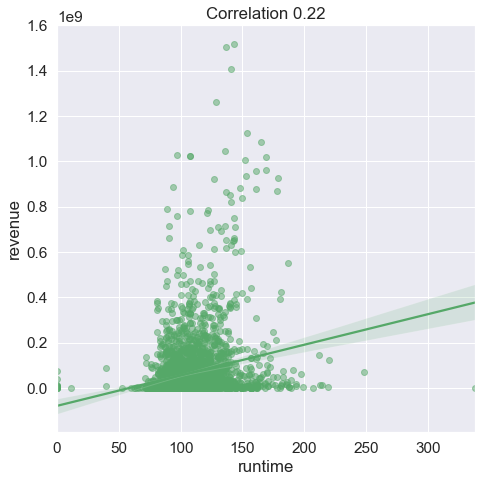

In [121]:
fig, ax = plt.subplots(figsize=(7,7))

sns.regplot(x=all_data['runtime'][:3000], y=all_data['revenue'][:3000], color='g', scatter_kws={'alpha': 0.5})
correlation = np.corrcoef(all_data['runtime'][:3000], all_data['revenue'][:3000])[0,1]
ax.set_title("Correlation {:.2f}".format(correlation))

plt.tight_layout()
plt.show()

### Log-transform

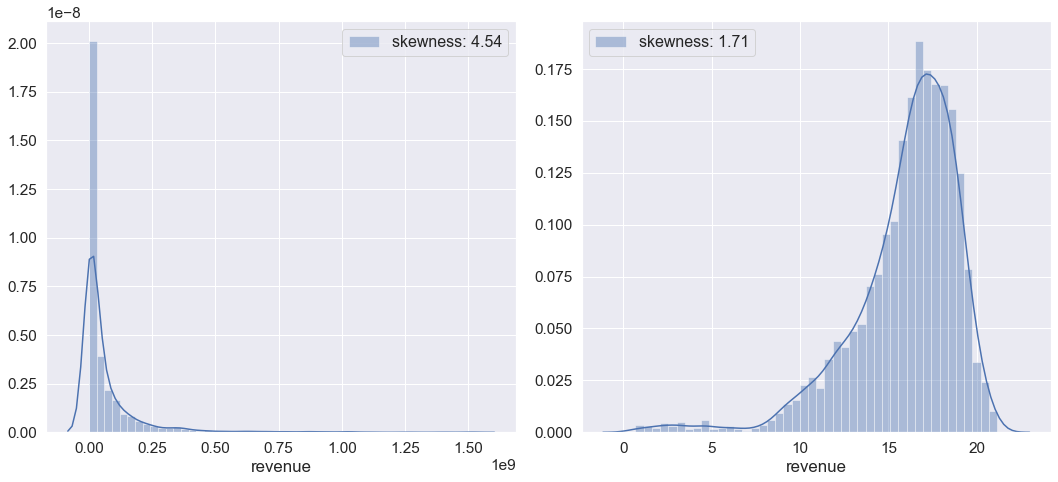

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
colors = sns.color_palette(n_colors=2)
sns.set(color_codes=True, font_scale=1.4)

g = sns.distplot(train_data["revenue"], ax = axes[0])
axes[0].legend(["skewness: {:.2f}".format(train_data["revenue"].skew())])
plt.setp(g.get_legend().get_texts(), fontsize='16')

g = sns.distplot(np.log1p(train_data["revenue"]), ax = axes[1])
axes[1].legend(["skewness: {:.2f}".format(np.log1p(train_data["revenue"].skew()))])
plt.setp(g.get_legend().get_texts(), fontsize='16')

plt.tight_layout()
plt.show()

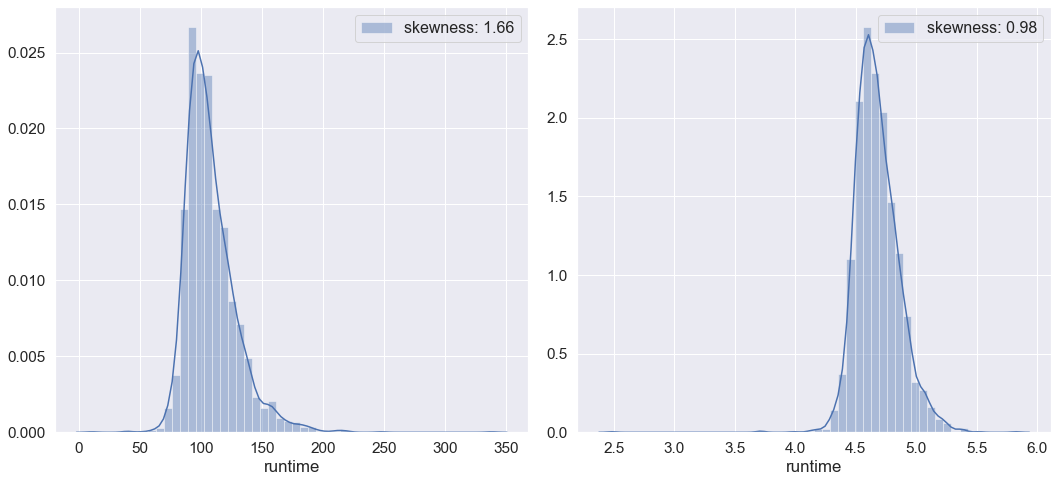

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
colors = sns.color_palette(n_colors=2)
sns.set(color_codes=True, font_scale=1.4)

g = sns.distplot(train_data["runtime"], ax = axes[0])
axes[0].legend(["skewness: {:.2f}".format(train_data["runtime"].skew())])
plt.setp(g.get_legend().get_texts(), fontsize='16')

g = sns.distplot(np.log1p(train_data["runtime"]), ax = axes[1])
axes[1].legend(["skewness: {:.2f}".format(np.log1p(train_data["runtime"].skew()))])
plt.setp(g.get_legend().get_texts(), fontsize='16')

plt.tight_layout()
plt.show()

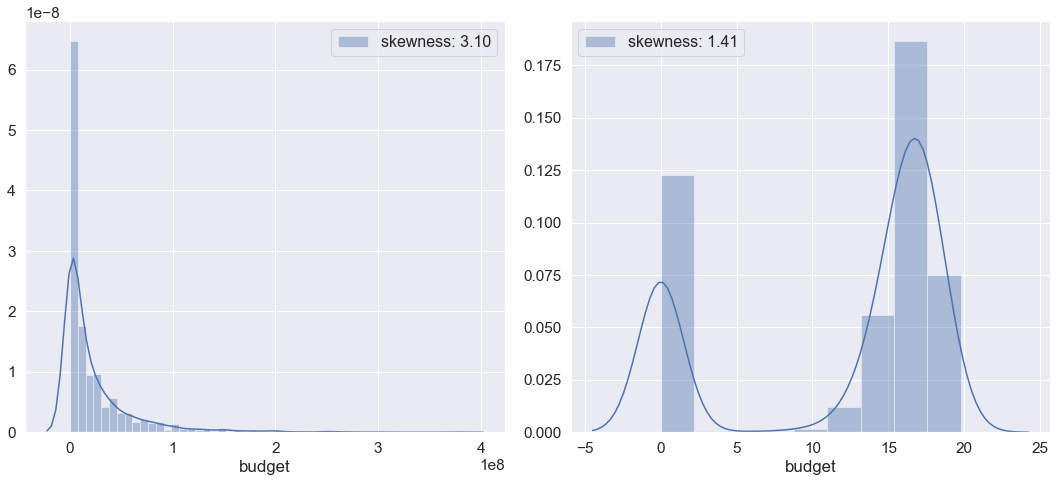

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
colors = sns.color_palette(n_colors=2)
sns.set(color_codes=True, font_scale=1.4)

g = sns.distplot(train_data["budget"], ax = axes[0])
axes[0].legend(["skewness: {:.2f}".format(train_data["budget"].skew())])
plt.setp(g.get_legend().get_texts(), fontsize='16')

g = sns.distplot(np.log1p(train_data["budget"]), ax = axes[1])
axes[1].legend(["skewness: {:.2f}".format(np.log1p(train_data["budget"].skew()))])
plt.setp(g.get_legend().get_texts(), fontsize='16')

plt.tight_layout()
plt.show()

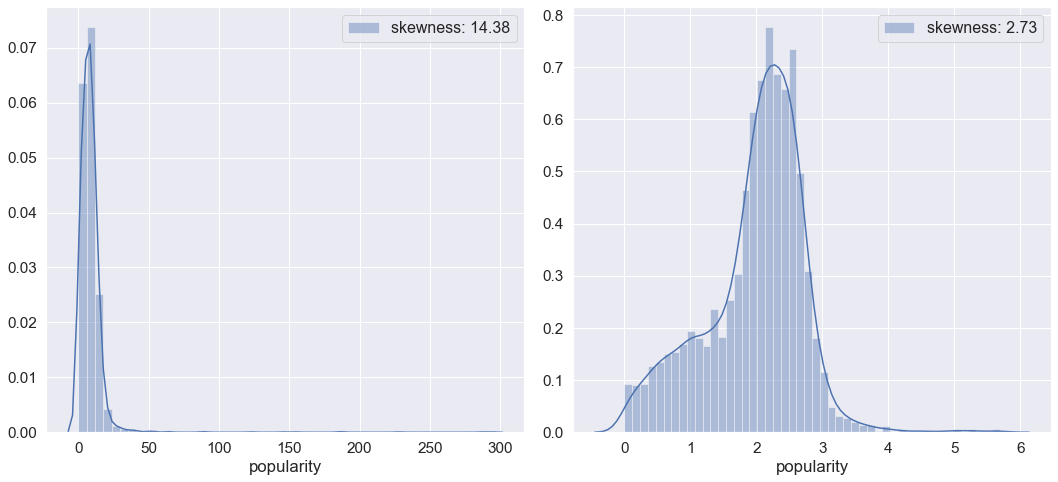

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
colors = sns.color_palette(n_colors=2)
sns.set(color_codes=True, font_scale=1.4)

g = sns.distplot(train_data["popularity"], ax = axes[0])
axes[0].legend(["skewness: {:.2f}".format(train_data["popularity"].skew())])
plt.setp(g.get_legend().get_texts(), fontsize='16')

g = sns.distplot(np.log1p(train_data["popularity"]), ax = axes[1])
axes[1].legend(["skewness: {:.2f}".format(np.log1p(train_data["popularity"].skew()))])
plt.setp(g.get_legend().get_texts(), fontsize='16')

plt.tight_layout()
plt.show()

In [126]:
# Apply log+1 transformations
all_data['revenue'][:3000] = np.log1p(all_data["revenue"][:3000])
all_data['runtime'] = np.log1p(all_data["runtime"])
all_data['budget'] = np.log1p(all_data["budget"])
all_data['popularity'] = np.log1p(all_data["popularity"])

The budget is problematic. There are too many zero-values and we need to fix those. One way is to predict those values using other features in our dataset.

In [127]:
(all_data['budget'] == 0).sum()

2023

In [128]:
budget_train_data = all_data.loc[all_data['budget'] != 0]
budget_test_data = all_data.loc[all_data['budget'] == 0]

In [129]:
budget_train_X = budget_train_data.drop(labels=['budget', 'revenue'], axis=1)
budget_train_Y = budget_train_data['budget']
budget_test_X = budget_test_data.drop(labels=['budget', 'revenue'], axis=1)

In [130]:
lr = LinearRegression()
lr.fit(budget_train_X, budget_train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [131]:
budget_Ypred = lr.predict(budget_test_X)

In [132]:
# Fill in the zero values with our prediction
all_data.loc[all_data['budget'] == 0, 'budget'] = budget_Ypred

## Get data ready for modeling

In [133]:
Y = all_data['revenue']
final_data = all_data.drop(labels=['revenue'], axis=1)

In [134]:
ss = StandardScaler()
rs = RobustScaler()
# final_data = ss.fit_transform(final_data)
final_data = rs.fit_transform(final_data)
# final_data = final_data.values

In [135]:
final_data.shape

(7398, 139)

In [136]:
Ytrain = Y[:train_size]
Xtrain = final_data[:train_size]
Xtest = final_data[train_size:]

# Modeling

In [137]:
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, Ytrain, test_size=0.1)

In [138]:
def CV_score(estimator, X, Y, score, n_folds=5):
    if score == 'explained_variance':
        score = np.mean(cross_val_score(estimator, X, Y, cv=n_folds, scoring='explained_variance', n_jobs=-1))
        print('Explained variance: %5f' % score)
    elif score == 'RMSE':
        score = np.mean(np.sqrt(-cross_val_score(estimator, X, Y, cv=n_folds, scoring='neg_mean_squared_error', n_jobs=-1)))
        print('Root mean squared error: %5f' % score)
    else:
        print('Metric not supported!')

In [139]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1.5, 
                             n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42, silent=1)

CV_score(model_xgb, Xtrain, Ytrain, score='RMSE')

Root mean squared error: 2.244683


In [140]:
# Random Forest
model_rf = RandomForestRegressor()

In [141]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

CV_score(GBoost, Xtrain, Ytrain, score='RMSE')

Root mean squared error: 2.089427


In [142]:
model_ElasticNet = ElasticNetCV()

CV_score(model_ElasticNet, Xtrain, Ytrain, score='RMSE')

Root mean squared error: 2.144402


In [143]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

CV_score(LightGB, Xtrain, Ytrain, score='RMSE')

Root mean squared error: 2.124613


In [144]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
# model1.fit(X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
#         verbose=1000, early_stopping_rounds=200)
CV_rmse(model1, Xtrain, Ytrain, score='explained_variance')

NameError: name 'CV_rmse' is not defined

In [ ]:
CV_score(model1, Xtrain, Ytrain, score='RMSE')

In [ ]:
ls = LassoCV()

In [ ]:
CV_score(ls, Xtrain, Ytrain, score='RMSE')

In [ ]:
model1.fit(Xtrain, Ytrain, verbose=1000)

In [ ]:
Y_pred = np.expm1(model1.predict(Xtest))

In [ ]:
results = pd.read_csv("./sample_submission.csv")
results["revenue"] = Y_pred
results.to_csv("./final_submission.csv", index=False)